# Basin impacts in another model or region
The following script is designed to produce another panel for Fig 7, with a different model or region.

It is much less efficient than the original scripts used to produce Fig 7, but it should work without needing to modify any additional files. It should run in <24 h on 8 cores with 64GB memory, and saves progress as it goes (but, obviously, time will blow out with more data). The bulk of the time is in the analogue calculation step -- if this cell needs to be restarted for any reason, it will save progress and skip the parts that are already calculated and saved.

If you want to do anything at scale, it's worth looking at e.g. `ensemble-analogue-predictability/other_examples/250131_areacorr/wrapper.sh` and the various levels it calls

To use this script, you will need at least 2000 years of model output. The example below uses the ACCESS-ESM1-5 large ensemble.

If anybody is actually reading this and wants to use this method, feel free to email Jemma Jeffree for assistance (jemma.jeffree@anu.edu.au, unless I've moved institutions)


## Read in a bunch of setup stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from xhistogram.xarray import histogram
import scipy.stats
import warnings
import time
import os
import sys
import inspect

In [2]:
import dask
dask.config.set({'distributed.admin.large-graph-warning-threshold':'1024MB'})
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35937,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37607,Total threads: 1
Dashboard: /proxy/39969/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43093,


## Add a handful of new bits of code to reflect your specific circumstances
## MODIFY THIS BIT ONLY

In [3]:
# Whereever you want to put stuff
working_directory = '/scratch/x77/jj8842/Fig7_tute_test4/'

# Wherever you have cloned the git/zenodo repository
repo_loc = '/g/data/x77/jj8842/ensemble-analogue-predictability/'
sys.path.append(repo_loc)
import predictability_tools as pt




In [4]:
import importlib.util

# Config file - saves a bunch of settings that in theory you might want to change
# In practice, I'd suggest just keeping this one though
config_file = repo_loc+'spinoff_EOF_configs/areacorr_eof_config.py'

spec = importlib.util.spec_from_file_location("args", config_file)
module = importlib.util.module_from_spec(spec)
sys.modules["args"] = module
spec.loader.exec_module(module)
args = sys.modules["args"]
print("Using config from "+config_file)

# let's overwrite some of the existing settings
args.outfolder_loc = working_directory
args.analogue_output_folder = working_directory+'results/'
if not os.path.isdir(args.analogue_output_folder):
    os.mkdir(args.analogue_output_folder)

data_name = 'ACCESS'
no_ensemble_members=40
args.analogue_time_slice[data_name] = slice('1855','1945') # may need to bodge this a little if shuffling a pi control around

Using config from /g/data/x77/jj8842/ensemble-analogue-predictability/spinoff_EOF_configs/areacorr_eof_config.py


In [5]:
# This is the bit you change so that this script knows where your data is
# I think I assume that data sits on a lat/lon grid

def get_model_ss(data_name='ACCESS-ESM1-5',
                 location = '/g/data/su28/MMLEAv2/ocean/monthly/',
                 time_slice = slice('1850','1949'),
                 member_names = np.arange(1,41,dtype=int).astype(str),
                 middle_bit = '_Omon_ACCESS-ESM1-5_historical_r',
                 var_list = ('tos','zos'),
                 tail = 'i1p1f1_g025_185001-201412.nc',
                           ):

    ss = []
    
    for var in var_list:
        filepaths = [location+var+'/'+data_name+'/'+var+middle_bit+mn+tail for mn in member_names]
    
        ss.append(xr.open_mfdataset(filepaths,
                            coords='minimal',
                            compat='override',
                            combine = 'nested',
                            concat_dim = ('SMILE_M',),
                            preprocess = lambda x: x[var].sel(time=time_slice),
                            chunks = {'lat':-1,'lon':-1,'time':-1,'SMILE_M':1},
                           parallel = True))
    
    
    full_model_ss = xr.concat(ss,'var').assign_coords({'var':np.array(var_list),'SMILE_M':member_names})

    means_file = working_directory+data_name+'mean.nc'
    if not(os.path.isfile(means_file)):
        pt.SMILE_means(full_model_ss,means_file) ###

    #Strip seasonal variability
    seasonal_mean = xr.load_dataset(means_file).seasonal_mean
    full_model_ss = pt.strip_climatology(full_model_ss,clim=seasonal_mean)

    #Strip global mean
    zos_global_mean = xr.load_dataset(means_file).zos_global_mean
    full_model_ss = full_model_ss.where(~(full_model_ss['var']=='zos'),full_model_ss-zos_global_mean)
    
    expected_dims = ('var','SMILE_M','time','lat','lon')
    for d in full_model_ss.dims:
        if d not in expected_dims:
            full_model_ss = full_model_ss.squeeze(d,drop=True)
    return full_model_ss

full_model_ss = pt.strip_ensemble_mean(get_model_ss(),working_directory+data_name+'_ensemble_mean.nc')

In [6]:
# Define the regions we are interested in comparing
mask_list = ('10P', #10S-10N in the Pacific
         '10P30A', #10S-10N in the Pacific and 30S-30N in the Atlantic
        )
# If any masks are not already defined, define them here:
# e.g. 
# pt.mask_dict['30P'] = pacific_mask.where(np.abs(pacific_mask['lat'])<30,0)
# see ensemble-analogue-predictability/predictability_tools/mask_definitions.py
# for other examples

vars = np.array(('tos','zos')) # note double brackets

## Any of the cells below can be run independently, if the cells above this line have been run, and the cells above that cell have been run at any point
(Ie, the cells need to run in order, but they save their data so if anything crashes you can just rerun the most recent part)

## Calculate weights

In [7]:
# From ensemble-analogue-predictability/spinoff_EOF_configs/correlation_area.py
t0 = time.time()

# Load relevant model data
model_ss = args.correlation_member_trim(full_model_ss).load()
print('Model data aquired; '+data_name+"; "+str(time.time()-t0)+' s')

# Calculate index for correlations
if inspect.isfunction(args.calc_corr_index) :
    corr_index = args.calc_corr_index(model_ss)
else:
    corr_index = args.calc_corr_index

# Calculate the coslat area weight bit
# This is square rooted because I want the MSE (not RMSE) to be weighted by area
# so it'll all get squared before being used
area_weights = np.abs(np.cos(np.deg2rad(model_ss.lat)))**0.5

print('Correlation index calculated; '+args.corr_index_name+'; '+str(time.time()-t0)+' s')
print('Writing to'+ args.outfolder_loc)

for init_month in args.init_months:
    month_model_ss = model_ss.where(model_ss['time.month']==init_month,drop=True).chunk(args.corr_chunks)
    month_corr_index = xr.concat([corr_index.shift(time=-l).where(corr_index['time.month']==init_month,drop=True)
                                  for l in args.leads],dim='L').assign_coords(L=args.leads).chunk({'L':6})

    with warnings.catch_warnings():
        warnings.simplefilter('once')
        out = xr.corr(month_corr_index,
                              month_model_ss,
                              dim=(args.time_dims)).load()

        # Multiply by area weighting
        out = out*area_weights
        

    for l in args.leads:
        out_folder = args.weight_folder_name_func(data_name,init_month,l)
        if os.path.isdir(out_folder):
            if not args.overwrite_correlation:
                print('skipping l='+str(l)+' init='+str(init_month))
                continue
        else:
            os.mkdir(out_folder) # Should throw an error if there was something there
        out.sel(L=l).to_netcdf(out_folder+'/weights.nc')
    print('Correlation init month ',init_month,time.time()-t0)
print('Done, '+str(time.time()-t0)+' s')

Model data aquired; ACCESS; 6.741536378860474 s
Correlation index calculated; NINO34; 9.220954895019531 s
Writing to/scratch/x77/jj8842/Fig7_tute_test4/


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/pu

Correlation init month  1 25.876393795013428
Correlation init month  2 41.969104290008545
Correlation init month  3 59.516743183135986
Correlation init month  4 75.96376609802246
Correlation init month  5 91.65848469734192
Correlation init month  6 108.55104494094849
Correlation init month  7 125.19243907928467
Correlation init month  8 141.93311214447021
Correlation init month  9 158.63328313827515
Correlation init month  10 175.9997615814209
Correlation init month  11 191.68267583847046
Correlation init month  12 208.83809280395508
Done, 208.8387713432312 s


## Calculate and save EOFs

In [8]:
t0 = time.time()
model_ss = args.eof_member_trim(full_model_ss).sel(var=vars).load()
print('Model data aquired; '+data_name+"; "+str(model_ss['var'].data)+'; '+str(time.time()-t0)+' s')
for mask in mask_list:
    print(mask)

    for init_month in args.init_months:
        month_model_ss = model_ss.where(((model_ss['time.month']==init_month)
                                                   ),drop=True)
        
        masked_model_ss = month_model_ss.where(pt.mask_dict[mask],drop=True)
        for l in args.leads:
            weightfolder_name = args.weight_folder_name_func(data_name,init_month,l)
            weights = xr.load_dataarray(weightfolder_name+'weights.nc')
            weighted_model_ss = masked_model_ss*weights
            assert (model_ss.dims == weighted_model_ss.dims), "weights are changing the dimensions of the data (BAD!!!). Check that you haven't lost the 'var' dim on model_ss"

            pt.calculate_trimmed_weighted_eof(weighted_model_ss,
                               weightfolder_name = weightfolder_name,
                               data_name = data_name+'_'+mask,
                               **args.calculate_eof_kwargs,
                              )
            
        print(init_month, time.time()-t0)
print('Done, '+str(time.time()-t0)+' s')

Model data aquired; ACCESS; ['tos' 'zos']; 4.236457824707031 s
10P
1 14.001742601394653
2 23.901374101638794
3 32.993778228759766
4 42.99912118911743
5 52.992000341415405
6 62.99972891807556
7 72.97529673576355
8 82.6950249671936
9 92.71630001068115
10 102.48069620132446
11 111.98133277893066
12 121.7043673992157
10P30A
1 149.7423393726349
2 176.44989156723022
3 203.4916853904724
4 232.970196723938
5 260.2067246437073
6 287.43283462524414
7 316.5042266845703
8 343.250057220459
9 369.9328429698944
10 397.16358065605164
11 426.4010241031647
12 454.2558059692383
Done, 454.2567627429962 s


## Project the rest of the data _onto_ those EOFs

In [9]:
# adapted from ensemble-analogue-predictability/pca_projection.py
t0=time.time()

eof_data_name = data_name # We're just looking at perfect model predictability

# We do things in pieces for the sake of memory
for Mi_start in range(0,no_ensemble_members,10):
    Mi_slice = slice(Mi_start,Mi_start+10)
    print(Mi_slice)

    model_ss = full_model_ss.isel(SMILE_M=Mi_slice)
    member_string = '_'+str(Mi_slice.start)+'-'+str(Mi_slice.stop)+'M'

    model_ss = model_ss.sel(var=vars).load()
    print('Model data loaded; '+str(time.time()-t0)+' s')
    print("Ensemble members "+str(Mi_slice))
    print("Variables "+str(model_ss['var'].data))

    for init_month in args.init_months:
        month_model_ss = model_ss.where(((model_ss['time.month']==init_month)
                                               ),drop=True)#.assign_coords({'nlat':model_ss.nlat,'nlon':model_ss.nlon})
        if np.prod(month_model_ss.shape)==0:
            warnings.warn("Skipping month "+str(init_month)+", couldn't find any data")
            continue
        for m in mask_list:
            trim_model_ss=month_model_ss.where(pt.mask_dict[m],drop=True)
            b = trim_model_ss.stack({'loc':args.space_dims,'time_stack':args.time_dims})
    
            for l in args.leads:
                weightfolder_name = args.weight_folder_name_func(eof_data_name,init_month,l)
                weights = xr.load_dataarray(weightfolder_name+'weights.nc')
                #weights = weights.assign_coords({'nlon':weights.nlon,'nlat':weights.nlat})
    
                weighted_b = b*weights.stack({'loc':args.space_dims})
    
                eof_folder = (weightfolder_name+'/'
                                +eof_data_name+'_'+m+'_'
                                +'_'.join(trim_model_ss['var'].data)
                                +'/')
    
                pt.fast_calculate_weighted_pca(weighted_b,
                                       eof_folder=eof_folder,
                                       data_name = data_name+'_'+m+member_string,
                                       **args.calculate_pca_kwargs
                                      )
            print(init_month, m, time.time()-t0)
print('Done, '+str(time.time()-t0)+' s')

slice(0, 10, None)
Model data loaded; 6.576674699783325 s
Ensemble members slice(0, 10, None)
Variables ['tos' 'zos']
1 10P 12.489957571029663
1 10P30A 20.799667596817017
2 10P 26.043450593948364
2 10P30A 34.78456258773804
3 10P 39.88604521751404
3 10P30A 47.73671245574951
4 10P 52.93040204048157
4 10P30A 61.37369394302368
5 10P 67.06162238121033
5 10P30A 74.65128445625305
6 10P 80.49339127540588
6 10P30A 88.72971439361572
7 10P 94.0219566822052
7 10P30A 102.24674272537231
8 10P 107.73820352554321
8 10P30A 116.38008236885071
9 10P 121.9633903503418
9 10P30A 129.67475748062134
10 10P 135.0152416229248
10 10P30A 143.6913571357727
11 10P 149.05064463615417
11 10P30A 157.15850806236267
12 10P 162.8726885318756
12 10P30A 171.1809425354004
slice(10, 20, None)
Model data loaded; 180.47409415245056 s
Ensemble members slice(10, 20, None)
Variables ['tos' 'zos']
1 10P 186.19198179244995
1 10P30A 194.37832903862
2 10P 199.795560836792
2 10P30A 207.43797969818115
3 10P 212.7623496055603
3 10P30A 2

## Calculate analogues

In [7]:
# adapted from ensemble-analogue-predictability/analogue_forecasting2.py
t0=time.time()
#The things that might want to be changed all the time
lib_data_name = corr_data_name = data_name # still only doing perfect model predictability
for lib_mi in range(no_ensemble_members//args.lib_size): # Libraries of 5 ensemble members
    def calc_index(ss):
        nino3 = pt.average_region(ss.sel(var='tos'),pt.nino3_region,
                                lon_coord = 'lon', lat_coord ='lat',lon_dim='lon',lat_dim='lat')
        nino34 = pt.average_region(ss.sel(var='tos'),pt.nino34_region,
                                lon_coord = 'lon', lat_coord ='lat',lon_dim='lon',lat_dim='lat')
        nino4 = pt.average_region(ss.sel(var='tos'),pt.nino4_region,
                                lon_coord = 'lon', lat_coord ='lat',lon_dim='lon',lat_dim='lat')
        return xr.concat((nino3,nino34,nino4),'index_lon').assign_coords(index_lon=np.array(('nino3','nino34','nino4')))

    # Read in data you need and calculate relevant indexes
    lib_index = calc_index(full_model_ss)
    data_index = lib_index
    print('Lib index calculated; '+lib_data_name+'; '+str(time.time()-t0)+' s')
        
    # Pick a 500 year library
    psn = args.pca_step_n #Easier to read than the full thing
    n_lib_files = np.ceil(no_ensemble_members/psn).astype(int)
    lib_members = lib_index.SMILE_M.isel(SMILE_M = slice(lib_mi*args.lib_size,lib_mi*args.lib_size+args.lib_size))
    lib_pca_trim = lambda x: x.sel(time=args.analogue_time_slice[lib_data_name],SMILE_M = lib_members
                                                                  ).stack({'lib_dim':('SMILE_M','time')})
    full_lib_time = lib_index.time

    # Use everything for verification ("obs" is just used a shorthand for verification, even in perfect-model setups)
    # Libraries with the initialisation included are discarded later
    n_obs_files = np.ceil(no_ensemble_members/psn).astype(int)
    obs_pca_trim = lambda x: x.sel(time=args.analogue_time_slice[data_name]).rename({'SMILE_M':'pred_SMILE_M'})
    full_obs_time = data_index.time


    for m in mask_list:
        lib_pca_names = [lib_data_name+'_'+m+'_'+str(i*psn)+'-'+str(i*psn+psn)+'M' for i in range(n_lib_files)]
        if n_obs_files>1:
            obs_pca_names = [data_name+'_'+m+'_'+str(i*psn)+'-'+str(i*psn+psn)+'M' for i in range(n_obs_files)]
        else:
            obs_pca_names = [data_name+'_'+m]

        out_filename = args.analogue_output_folder+data_name+'_'+'_'.join(vars)+'/'+m+'_'+str(lib_mi)+'.nc'
        if not os.path.isdir('/'.join(out_filename.split('/')[:-1])):
            os.mkdir('/'.join(out_filename.split('/')[:-1])) # Should also throw an error if there's any other problems with this directory existing
        if os.path.isfile(out_filename):
            warnings.warn('Skipping ' + out_filename)
            continue
        else:
            warnings.warn('Attempting to calculate ' + out_filename)

        output_i = []
        for init_month in args.init_months:
            output_l = []
            for l in args.leads:
                pca_folder = (args.weight_folder_name_func(corr_data_name,init_month,l)+corr_data_name+'_'+m+'_'
                             +'_'.join(vars)
                             +'/')
    
                # Set up the initialisations
                obs_pca = xr.open_mfdataset([pca_folder+'pca_'+opn+'.nc' for opn in obs_pca_names],
                                            combine='nested',
                                            concat_dim=('SMILE_M',)).pca.load()
                obs_pca = obs_pca_trim(obs_pca)
                

                init_i = np.where(obs_pca['time.month']==init_month)[0]
                init_ens = (obs_pca.isel(time=xr.DataArray(init_i,dims='Y')) # Pick out the points where we're starting. 
                                                                             # In many cases this may not do anything
                                    .rename(time='pred_time')                # Separate predicted time from the time later used in archive
                                   )
                # Find me some analogue initialisations
                # Library/archive to find analogues in
                lib_pca = xr.open_mfdataset([pca_folder+'pca_'+lpn+'.nc' for lpn in lib_pca_names],
                                            combine='nested',
                                            concat_dim=('SMILE_M',)).pca.load()
                lib_pca = lib_pca_trim(lib_pca)
                lib_pca = lib_pca.where(lib_pca['time.month'] == init_month,drop=True)
                assert lib_pca.time.shape[0]>0, 'No library. Probably initialisation times don\'t match'
                #print(time.time()-t0)
                assert (np.sum(np.isnan(lib_pca))+np.sum(np.isnan(obs_pca)))==0, 'NaNs in your PCA. FIX'
                weights = xr.load_dataset(pca_folder+'eof.nc').variance_fraction
                distance = ((init_ens-lib_pca.chunk(lib_dim=args.lib_dim_chunk_size))**2*weights).sum('mode').load()
                analogue_i = distance.transpose('lib_dim',...).argsort(axis=0)[:args.n_analogues].reset_index('lib_dim',drop=True).rename({'lib_dim':'M'})
                assert not(('SMILE_M' in analogue_i.coords) or ('time' in analogue_i.coords)), 'Dunno where either came from but could stuff up analogue selection'
                analogue = distance.isel(lib_dim = analogue_i)
                #print(time.time()-t0)
                # Do some massaging to get the data back out again tidily
                analogue_forecast_time = full_lib_time.shift(time=-l).sel(time=analogue.time)
                init_forecast_time = full_obs_time.shift(time=-l).sel(time=init_ens.pred_time)
            
                #print(time.time()-t0)
                forecast = (analogue
                 .drop_vars(('lib_dim','time','pred_time'))
                 .assign_coords({'analogue_time':analogue_forecast_time.drop_vars(('lib_dim','pred_time','pred_SMILE_M')),
                                 'pred_time':init_forecast_time,
                                 }
                               ).rename('analogue_distance').rename({'SMILE_M':'analogue_SMILE_M'})
                 .assign_coords({'L':l}).expand_dims('L')
                            )
                output_l.append(forecast)
    
            output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
            warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
    
        out =  xr.concat(output_i,'init_month')
        ver = data_index.sel(time=out.pred_time,SMILE_M=out.pred_SMILE_M)
        an_forecast = lib_index.sel(time=out.analogue_time,SMILE_M=out.analogue_SMILE_M)
    
        trim_forecast = (an_forecast.mean('M'))
        if data_name == lib_data_name:
            trim_forecast = trim_forecast.where(~trim_forecast.pred_SMILE_M.isin(lib_members)) ### drop self-referential analogues
        if 'SMILE_M' in ver.coords:
            ver = ver.drop_vars('SMILE_M')
        out_data = xr.Dataset({'verification':ver.drop_vars(('time')),
                               'forecast':trim_forecast}
                             ).expand_dims({'mask':(m,),'lib_mi':(lib_mi,)}).drop_vars(('var'))
        
        out_data.to_netcdf(out_filename)
        print(out_filename.split('/')[-1],str(time.time()-t0))
    print('done')

Lib index calculated; ACCESS; 17.517914295196533 s
done


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_0.nc
  warnings.warn('Skipping ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_0.nc
  warnings.warn('Skipping ' + out_filename)


Lib index calculated; ACCESS; 33.4693603515625 s
done


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_1.nc
  warnings.warn('Skipping ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_1.nc
  warnings.warn('Skipping ' + out_filename)


Lib index calculated; ACCESS; 52.22085404396057 s
done


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_2.nc
  warnings.warn('Skipping ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_2.nc
  warnings.warn('Skipping ' + out_filename)


Lib index calculated; ACCESS; 72.48599743843079 s
done


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_3.nc
  warnings.warn('Skipping ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_3.nc
  warnings.warn('Skipping ' + out_filename)


Lib index calculated; ACCESS; 90.01901173591614 s
done


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_4.nc
  warnings.warn('Skipping ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:46: UserWarning: Skipping /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_4.nc
  warnings.warn('Skipping ' + out_filename)


Lib index calculated; ACCESS; 105.96739220619202 s


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_5.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 5 1 175.70225620269775
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578/22

10P_5.nc 966.2636766433716


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_5.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 5 1 1050.3998832702637
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578

10P30A_5.nc 2045.4313704967499
done
Lib index calculated; ACCESS; 2156.7263736724854 s


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_6.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 6 1 2246.1263580322266
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578/22

10P_6.nc 3266.4913914203644


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_6.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 6 1 3357.9429483413696
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578

10P30A_6.nc 4431.109463214874
done
Lib index calculated; ACCESS; 4460.972611188889 s


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P_7.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 7 1 4555.586928606033
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578/225

10P_7.nc 5698.542010307312


/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:49: UserWarning: Attempting to calculate /scratch/x77/jj8842/Fig7_tute_test4/results/ACCESS_tos_zos/10P30A_7.nc
  warnings.warn('Attempting to calculate ' + out_filename)
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:102: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  output_i.append(xr.concat(output_l,'L').assign_coords({'init_month':init_month}).expand_dims('init_month'))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2255438931.py:103: UserWarning: 7 1 5815.26087474823
  warnings.warn(str(lib_mi)+' '+str(init_month)+' '+str(time.time()-t0))
/jobfs/157445880.gadi-pbs/ipykernel_730578/2

10P30A_7.nc 7185.709800481796
done


## plot :)
These cells are relatively fast, and need to be run as a block

In [7]:
def incremental_sailboat2(skill,
                    N = 40*90*7,
                    start_mask = ('30P','30P','30P'),
                    later_mask=('30P30A','30P30I','60P'),
                    skill_type='corr',
                    vlim=(-0.075,0.075),
             fig = None,
             axs = None,
             cb_axs=None,

    ):
    assert not(0 in skill.init_month), 'Month should have coordinates'
    if skill_type=='corr':
        diff_func = lambda x,y: y**2-x**2
        cmap = 'BrBG'
        def stat_sig(r,r1):
            S = np.sqrt(1/(N-3))

            z = (np.arctanh(r1)-np.arctanh(r))/S
            
            # stat_sig = xr.ones_like(z).where(np.abs(z)>1.96)
            # if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
            #     pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,'linestyle':'dotted'}) #I think xshift is 1st month???

            stat_sig = xr.ones_like(z).where(np.abs(z)>2.58)
            if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':1,}) #I think xshift is 1st month???
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'

    elif skill_type=='mse':
        diff_func = lambda x,y: ((y-x)/x)*100
        cmap = 'BrBG_r'

        def stat_sig(r,r1):
                F = r1/r

                p_good = scipy.stats.f.cdf(r1/r,N-2,N-2)
                p_bad = scipy.stats.f.cdf(r/r1,N-2,N-2)
                p = np.min((p_good,p_bad),axis=0)
                
                stat_sig = xr.ones_like(F).where(p<0.01)
                if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                    pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,})#'linestyle':'dotted' #I think xshift is 1st month???

        clabel0 = 'MSE'
        clabel = '% MSE change'
    elif skill_type=='first_only':
        diff_func = lambda x,y: x**2
        cmap = 'BuGn'

        def stat_sig(r,r1):
            return None
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'
    else:
        assert False, 'need a skill type'

    if fig is None:
        assert axs is None, 'Either pass both axs and fig or neither'
        fig, axs = plt.subplots(1,len(later_mask)+1,figsize=((len(later_mask)+1)*4,8),
                               sharex=True,sharey=True)
    elif axs is None:
        assert False, 'Either pass both axs and fig or neither'
        
    if cb_axs is None:
        cb_axs=axs

    assert len(later_mask) == len(start_mask), 'later and start mask must be paired'
    for ax_i in range(len(later_mask)):
        plt.sca(axs)

        r = skill.sel(mask=start_mask[ax_i])
        r1 = skill.sel(mask=later_mask[ax_i])

        scatter = plt.pcolormesh(((r.init_month+r.L*0-5)%12+5).roll(init_month=-4),
            (r.init_month*0+r.L).roll(init_month=-4),
            diff_func(r,r1).roll(init_month=-4),
            cmap=cmap,
                                 #marker='s',s=100,
                                 vmin=vlim[0],vmax=vlim[1])
        stat_sig(r,r1)

        plt.xticks((13,7,),('Jan','Jul',),)#size=32)
        plt.xlabel('initialisation',size=20)
        axs.yaxis.set_tick_params(size=30,width=2,color='grey')
        axs.xaxis.set_tick_params(size=15,width=2,color='grey')


    cbar = fig.colorbar(scatter, 
                        ax=cb_axs,
                        orientation='horizontal', 
                        fraction=.2,
                         extend='both',
                        pad=0.2,
                        aspect=45*len(later_mask),
                       )
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(clabel, fontsize=20)
    return axs

In [8]:
r_list = []
for m in mask_list:   
    fct = xr.open_mfdataset(working_directory+'results/'+data_name+'_tos_zos/'+m+'_*.nc').sel(index_lon='nino34')
    assert fct.mask.shape == (1,)
    r_list.append(xr.corr(fct.verification,fct.forecast,('Y','pred_SMILE_M','lib_mi')).load())
    fct.close()
    print(m)
r = xr.concat(r_list,'mask')

10P
10P30A


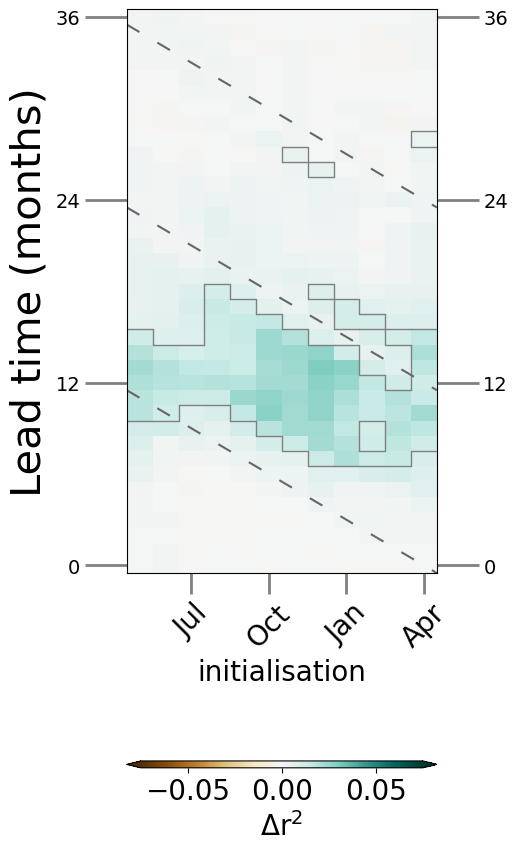

In [10]:
fig,ax =plt.subplots(1,1,figsize=(4,12.2))

incremental_sailboat2(r,
                      N = no_ensemble_members*91*(no_ensemble_members//5-1),
                    start_mask = (mask_list[0],),
                    later_mask=(mask_list[1],),
                    skill_type='corr',
                    vlim=(-0.075,0.075),
                      fig=fig,
                      axs=ax,
                     )

ax.set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
ax.tick_params(right=True,labelright=True)
ax.set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)

ax.set_ylabel('Lead time (months)',size=30)
ax.set_xlabel('initialisation',size=20)

ax.set_xticks([7,10,13,16],['','','',''],size=20,rotation=45)
ax.set_xticks([7,10,13,16],['Jul','Oct','Jan','Apr'],size=20,rotation=45)

for inc in (0,12,24,):
    ax.plot((4.5,16.5),np.array((11.5,-0.5))+inc,c='#666666',linestyle =(0, (7, 10)))